This notebook is designed to analyze comments from the YouTube video https://www.youtube.com/watch?v=VzjoHtYN05k&t=3027s with the goal of performing entity-level sentiment analysis on all participants in the debate. The objective is to identify which group gained the most positive impressions. To achieve this, I have integrated two pre-trained models from Hugging Face: one for Named Entity Recognition (NER) and another for sentiment classification using one-shot classification. By combining these models into a pipeline, the aim is to gain insights into the sentiment expressed by different entities participating in the video discussion.

In [1]:
!pip3 install -q emoji==0.6.0 tqdm pandarallel gputil psutil humanize
!git clone -q https://huggingface.co/tomaarsen/span-marker-mbert-base-multinerd
!git clone -q https://huggingface.co/facebook/bart-large-mnli
!pip install -q ipython-autotime
!pip install -q span_marker

%load_ext autotime

from tqdm import tqdm
import warnings

# To filter out all warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 888.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 780.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
time: 1.02 s (started: 2023-12-26 14:19:34 +00:00)


In [2]:
import pandas as pd

# Specify the CSV file path
csv_file_path = "comments.csv"

# Read comments from CSV into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df)

                                                 comment
0      This whole interview can be summarised into “y...
1      Muslims can go to UAE if they’re seeking econo...
2      Robert the clown Spence needs to enrol in reli...
3      Basically from this interview: The primary obs...
4              Let's have another Religious Roundtable 💚
...                                                  ...
21355                        Invite David Wood next week
21356                            2 Muslims vs 2 Liberals
21357                                     CHRIST IS KING
21358                                         ✝️✝️✝️✝️✝️
21359  Pat why you not bring Sam Shamoun to the Relig...

[21360 rows x 1 columns]
time: 159 ms (started: 2023-12-26 14:19:35 +00:00)


In [17]:
# Extract the first 100 rows and create a new DataFrame
data_subset = df.head(20000).copy()

# Display the new DataFrame
print(data_subset)

                                                 comment
0      This whole interview can be summarised into “y...
1      Muslims can go to UAE if they’re seeking econo...
2      Robert the clown Spence needs to enrol in reli...
3      Basically from this interview: The primary obs...
4              Let's have another Religious Roundtable 💚
...                                                  ...
19995                 Rashid is doing what on the show??
19996  Never thought in my wildest dream that Laura I...
19997  Daniel Haqiqatjou is an idiot who studied at H...
19998     Rachid was making up stuff as he went along...
19999  Jesus is not god in the old testaments jesus i...

[20000 rows x 1 columns]
time: 5.68 ms (started: 2023-12-26 14:45:49 +00:00)


In [18]:
from transformers import pipeline
from span_marker import SpanMarkerModel


pretrained_sentiment = "bart-large-mnli"
pretrained_ner = "span-marker-mbert-base-multinerd"

time: 618 µs (started: 2023-12-26 14:45:51 +00:00)


In [19]:
from transformers import pipeline
from span_marker import SpanMarkerModel

# Initialize the NER model once outside the function
ner_model = SpanMarkerModel.from_pretrained(pretrained_ner).cuda()

# Function to extract 'PER' entities from the 'entities' column
def extract_per_entities(entities):
    return [entity['span'] for entity in entities if entity['label'] == 'PER']

def ner_and_extract_per(text, model):
    try:
        entities = model.predict(text)
        per_entities = extract_per_entities(entities)
        return per_entities
    except Exception as e:
        print(f"Exception in NER processing: {e}")
        return []

time: 4.52 s (started: 2023-12-26 14:45:52 +00:00)


In [20]:
data_subset['entities'] = data_subset['comment'].progress_apply(lambda x: ner_and_extract_per(x, ner_model))

 26%|██▌       | 5180/20000 [09:03<20:31, 12.04it/s]

Exception in NER processing: `SpanMarkerModel.predict` could not recognize your input. It accepts the following:
* str: a string sentence.
* List[str]: a pre-tokenized string sentence, i.e. a list of words.
* List[str]: a list of multiple string sentences.
* List[List[str]]: a list of multiple pre-tokenized string sentences, i.e. a list with lists of words.
* Dataset: A 🤗 Dataset with `tokens` column and optionally `document_id` and `sentence_id` columns.
    If the optional columns are provided, they will be used to provide document-level context.


100%|██████████| 20000/20000 [33:16<00:00, 10.02it/s]

time: 33min 16s (started: 2023-12-26 14:45:56 +00:00)


In [21]:
data_subset.head()

,comment,entities
0,This whole interview can be summarised into “y...,[]
1,Muslims can go to UAE if they’re seeking econo...,[]
2,Robert the clown Spence needs to enrol in reli...,[Spence]
3,Basically from this interview: The primary obs...,[Brother Rachid]
4,Let's have another Religious Roundtable 💚,[]


time: 11.1 ms (started: 2023-12-26 15:19:13 +00:00)


In [22]:
sentiment_model = pipeline(
    "zero-shot-classification",
    model=pretrained_sentiment,
    return_all_scores=True,
    device=0
)

def zero_shot_sentiment_analysis(row, model):
  if not row['entities']:
    return {}
  candidate_labels = ["positive", "negative", "neutral"]
  result = {}
  for entity in row['entities'] :
    hypothesis_template = f"the sentiment towards {entity} is {{}}."
    output = model([row['comment']], candidate_labels, hypothesis_template=hypothesis_template)

    # Extract the first element of the list (assuming it contains the most relevant results)
    top_result = output[0]

    # Convert the list of dictionaries to a single dictionary
    label_score = {label: score for label, score in zip(top_result['labels'], top_result['scores'])}

    result[entity] = max(label_score, key=label_score.get)

  return result


time: 5.74 s (started: 2023-12-26 15:19:13 +00:00)


In [ ]:
data_subset['ner_sentiment_analysis'] = data_subset.progress_apply(lambda row: zero_shot_sentiment_analysis(row, sentiment_model), axis=1)


 98%|█████████▊| 19561/20000 [28:18<01:32,  4.75it/s]

In [ ]:
data_subset.head(20)

In [32]:
import pandas as pd

# Assuming 'data_subset' is your original DataFrame
# Drop rows with empty dictionaries
data = data_subset[data_subset['ner_sentiment_analysis'].notna() & (data_subset['ner_sentiment_analysis'] != {})]

# Flatten the dictionaries and create a new DataFrame
flattened_data = pd.DataFrame([(entity, sentiment) for entities in data['ner_sentiment_analysis'] for entity, sentiment in entities.items()], columns=['Entity', 'Sentiment'])

# Remove non-alphabetical characters and convert to lowercase
# flattened_data['Entity'] = flattened_data['Entity'].str.replace("[^a-zA-Z\s]", "").str.upper()

# Group by 'Entity' and 'Sentiment', then count occurrences
grouped_data = flattened_data.groupby(['Entity', 'Sentiment']).size().reset_index(name='Count')

# Add a new column for the total sentiment count per entity
grouped_data['TotalSentimentCount'] = grouped_data.groupby('Entity')['Count'].transform('sum')

# Select the top 10 entities based on 'TotalSentimentCount'
top_entities = grouped_data.groupby('Entity').agg({'TotalSentimentCount': 'max'}).nlargest(20, 'TotalSentimentCount')

# Merge with the original grouped data to keep all sentiments for the top 10 entities
result = pd.merge(top_entities[['TotalSentimentCount']], grouped_data, on=['Entity', 'TotalSentimentCount'], how='left')

# Display the top 10 entities and all sentiments
print(result)


            Entity  TotalSentimentCount Sentiment  Count
0            Jesus                 1233  negative    660
1            Jesus                 1233   neutral     68
2            Jesus                 1233  positive    505
3           Daniel                  914  negative    399
4           Daniel                  914   neutral     17
5           Daniel                  914  positive    498
6           Rashid                  813  negative    699
7           Rashid                  813   neutral     10
8           Rashid                  813  positive    104
9             Jake                  631  negative    246
10            Jake                  631   neutral      7
11            Jake                  631  positive    378
12         Patrick                  525  negative    193
13         Patrick                  525   neutral     12
14         Patrick                  525  positive    320
15          Rachid                  522  negative    447
16          Rachid             

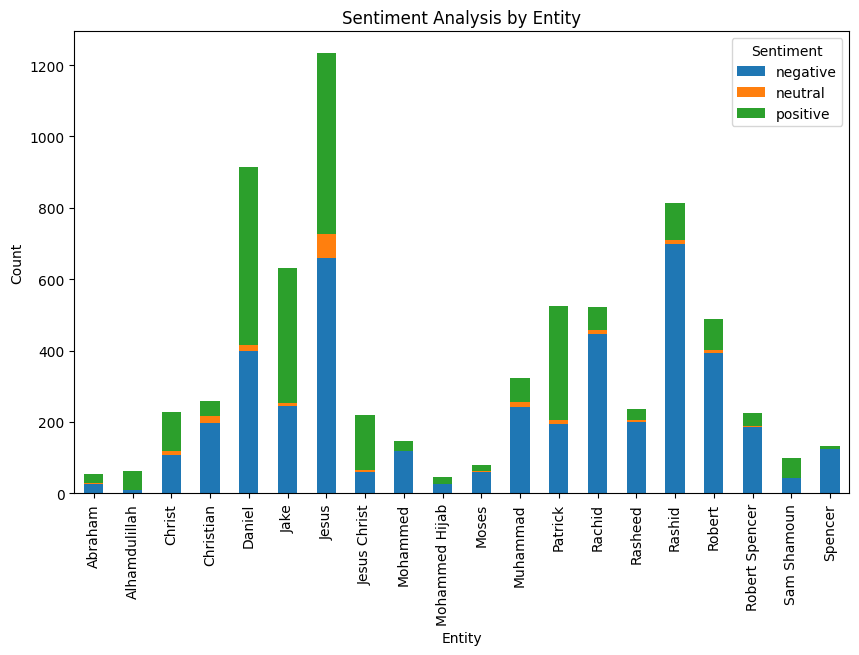

time: 366 ms (started: 2023-12-26 16:11:20 +00:00)


In [33]:
import matplotlib.pyplot as plt

# Pivot the DataFrame for easier plotting
pivot_data = result.pivot(index='Entity', columns='Sentiment', values='Count').fillna(0)

# Plotting
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Count')
ax.set_xlabel('Entity')
ax.set_title('Sentiment Analysis by Entity')

# Show the plot
plt.show()

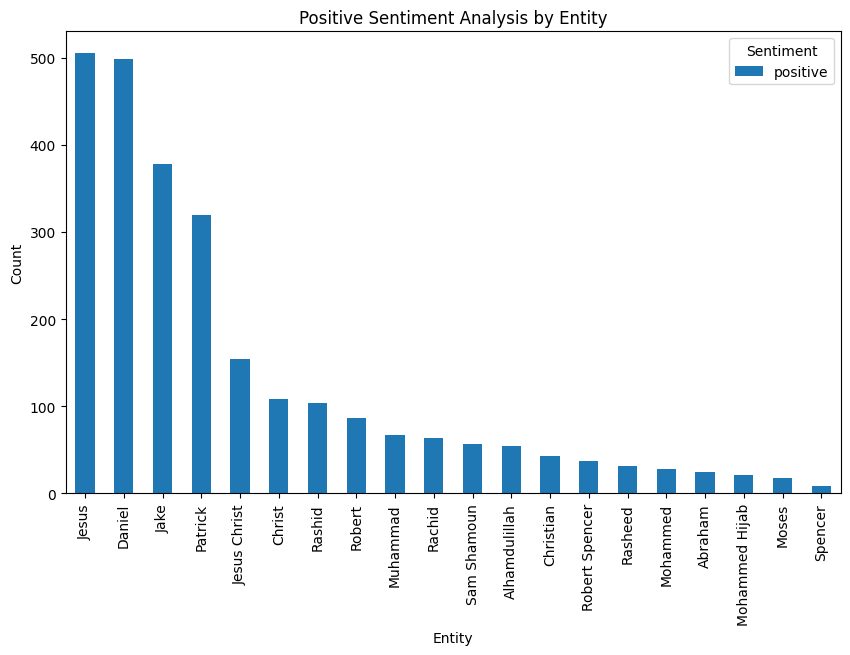

time: 307 ms (started: 2023-12-26 16:13:37 +00:00)


In [34]:
import matplotlib.pyplot as plt

# Pivot the DataFrame for easier plotting
pivot_data = result.pivot(index='Entity', columns='Sentiment', values='Count').fillna(0)

# Filter to keep only the positive sentiment count
positive_counts = pivot_data['positive']

# Order the entities based on positive sentiment count in descending order
ordered_entities = positive_counts.sort_values(ascending=False).index

# Plotting
ax = pivot_data.loc[ordered_entities, ['positive']].plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Count')
ax.set_xlabel('Entity')
ax.set_title('Positive Sentiment Analysis by Entity')

# Show the plot
plt.show()


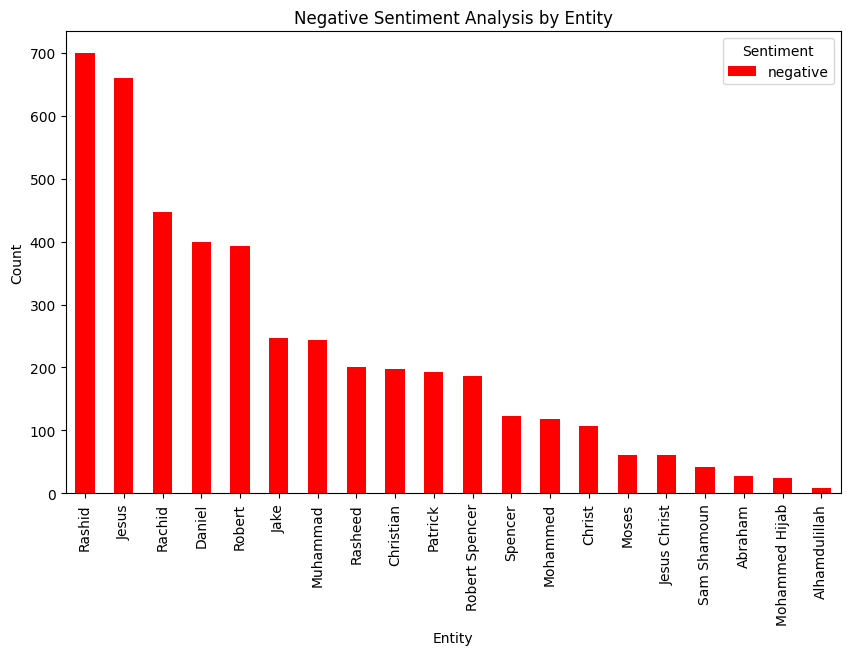

time: 641 ms (started: 2023-12-26 16:15:26 +00:00)


In [35]:
import matplotlib.pyplot as plt

# Pivot the DataFrame for easier plotting
pivot_data = result.pivot(index='Entity', columns='Sentiment', values='Count').fillna(0)

# Filter to keep only the negative sentiment count
negative_counts = pivot_data['negative']

# Order the entities based on negative sentiment count in descending order
ordered_entities_negative = negative_counts.sort_values(ascending=False).index

# Plotting for negative sentiments
ax_negative = pivot_data.loc[ordered_entities_negative, ['negative']].plot(kind='bar', stacked=True, figsize=(10, 6), color='red')
ax_negative.set_ylabel('Count')
ax_negative.set_xlabel('Entity')
ax_negative.set_title('Negative Sentiment Analysis by Entity')

# Show the negative plot
plt.show()


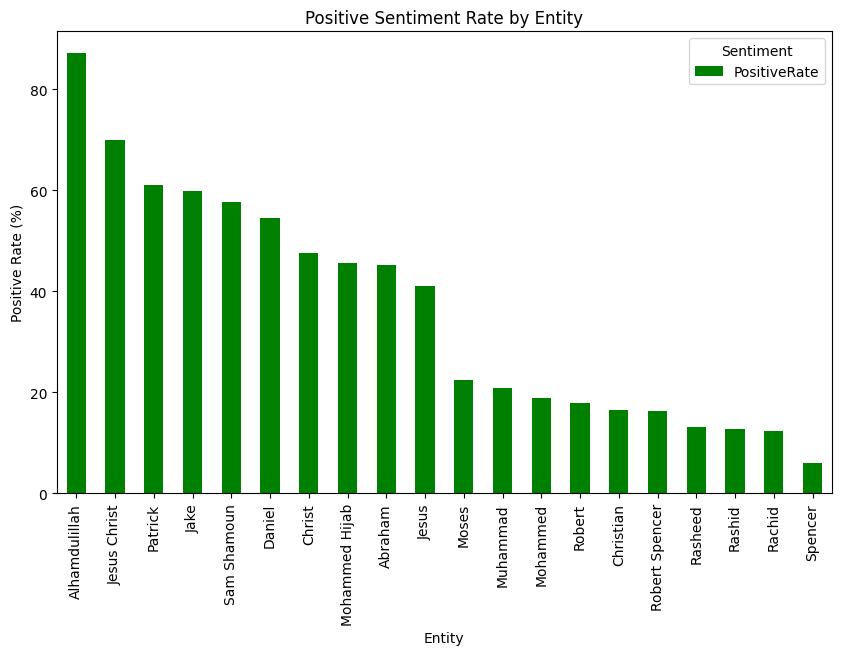

time: 886 ms (started: 2023-12-26 16:16:52 +00:00)


In [37]:
import matplotlib.pyplot as plt

# Pivot the DataFrame for easier plotting
pivot_data = result.pivot(index='Entity', columns='Sentiment', values='Count').fillna(0)

# Calculate the positive sentiment rate (percentage)
pivot_data['PositiveRate'] = (pivot_data['positive'] / pivot_data.sum(axis=1)) * 100

# Order the entities based on positive sentiment rate in descending order
ordered_entities_positive_rate = pivot_data['PositiveRate'].sort_values(ascending=False).index

# Plotting for positive sentiment rate
ax_positive_rate = pivot_data.loc[ordered_entities_positive_rate, ['PositiveRate']].plot(kind='bar', stacked=True, figsize=(10, 6), color='green')
ax_positive_rate.set_ylabel('Positive Rate (%)')
ax_positive_rate.set_xlabel('Entity')
ax_positive_rate.set_title('Positive Sentiment Rate by Entity')

# Show the positive rate plot
plt.show()


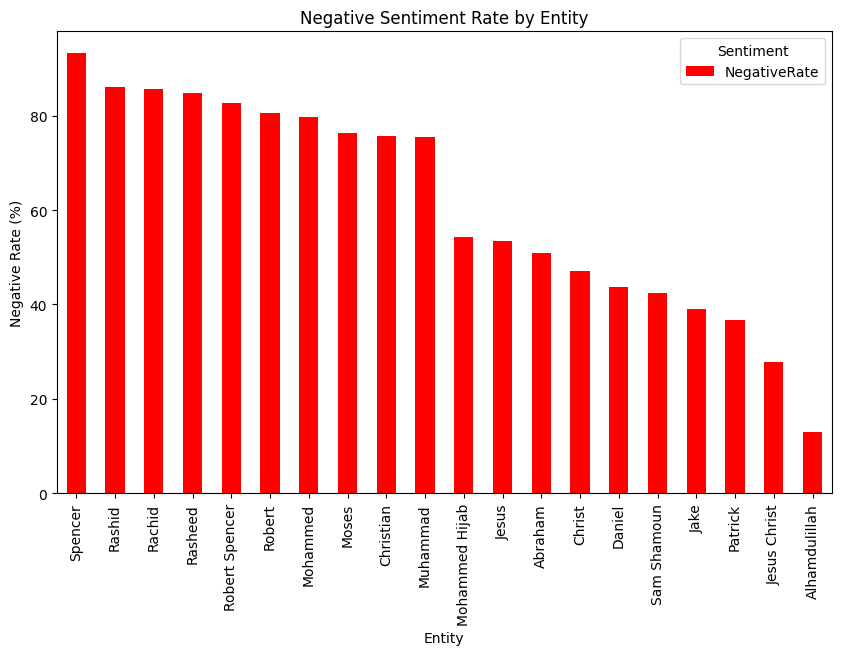

time: 324 ms (started: 2023-12-26 16:16:10 +00:00)


In [36]:
import matplotlib.pyplot as plt

# Pivot the DataFrame for easier plotting
pivot_data = result.pivot(index='Entity', columns='Sentiment', values='Count').fillna(0)

# Calculate the negative sentiment rate (percentage)
pivot_data['NegativeRate'] = (pivot_data['negative'] / pivot_data.sum(axis=1)) * 100

# Order the entities based on negative sentiment rate in descending order
ordered_entities_negative_rate = pivot_data['NegativeRate'].sort_values(ascending=False).index

# Plotting for negative sentiment rate
ax_negative_rate = pivot_data.loc[ordered_entities_negative_rate, ['NegativeRate']].plot(kind='bar', stacked=True, figsize=(10, 6), color='red')
ax_negative_rate.set_ylabel('Negative Rate (%)')
ax_negative_rate.set_xlabel('Entity')
ax_negative_rate.set_title('Negative Sentiment Rate by Entity')

# Show the negative rate plot
plt.show()


In [38]:
# Save the DataFrame to a CSV file
data_subset.to_csv("after_all.csv", index=False)

# Confirm that the CSV file has been saved
print(f'DataFrame has been saved to {csv_file_path}')

DataFrame has been saved to comments.csv
time: 182 ms (started: 2023-12-26 16:18:52 +00:00)
